HDF5 Compatibility problem:
**RUN THIS BEFORE JUPYTER!**

```
export HDF5_DISABLE_VERSION_CHECK=1
```

In [5]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import cm
from copy import deepcopy
import multidop
import pyart
import read_brazil_radar as rbr
import tempfile
import os
import glob
import time
from ast import literal_eval
%matplotlib inline

In [6]:
def read_dealise_radar(filename, dbz_field='corrected_reflectivity',
                       vel_field='corrected_velocity'):
    #- Reading radar file
    try:
        radar = pyart.aux_io.read_gamic(filename)
    except:
        radar = rbr.read_rainbow_hdf5(filename)
    
    #- Correct dealising
    cp = deepcopy(radar.fields[dbz_field]['data'])
    radar.add_field_like(dbz_field, 'DT', cp, replace_existing=True)
    gatefilter = pyart.correct.GateFilter(radar)
    gatefilter.exclude_masked(dbz_field)
    corr_vel = pyart.correct.dealias_region_based(radar, vel_field=vel_field,
                                                  keep_original=False, 
                                                  gatefilter=gatefilter,
                                                  centered=True)
    radar.add_field('VT', corr_vel, replace_existing=True)
    
    #- Correct missing_value and _FillValue fields
    try:
        radar.fields['DT']['missing_value'] = 1.0 * radar.fields['DT']['_FillValue']
    except:
        radar.fields['DT']['missing_value'] = 1.0 * radar.fields['DT']['data'].fill_value
        radar.fields['DT']['_FillValue'] = radar.fields['DT']['data'].fill_value
    
    return radar

In [7]:
def grid_radar(radar, grid_shape=(20, 301, 301), xlim=(-150000, 150000),
               ylim=(-150000, 150000), zlim=(1000, 20000),
               fields=['DT', 'VT'], origin=None):
    bt = time.time()
    radar_list = [radar]
    if origin is None:
        origin = (radar.latitude['data'][0],
                  radar.longitude['data'][0])
    grid = pyart.map.grid_from_radars(
        radar_list, grid_shape=grid_shape,
        grid_limits=(zlim, ylim, xlim),
        grid_origin=origin, fields=fields,
        gridding_algo='map_gates_to_grid', grid_origin_alt=0.0)
    print(time.time()-bt, 'seconds to grid radar')
    grid = multidop.angles.add_azimuth_as_field(grid)
    grid = multidop.angles.add_elevation_as_field(grid)
    return grid

In [8]:
def plot_gridded_radar(radar, name_radar, name_base, xlim=[-200, 10], ylim=[-10, 200]):
    fig = plt.figure(figsize=(6, 5))
    fig.set_facecolor('w')
    DZcomp = np.amax(radar.fields['DT']['data'], axis=0)
    x, y = np.meshgrid(0.001*radar.x['data'], 0.001*radar.y['data'])
    cs = plt.pcolormesh(0.001*radar.x['data'], 0.001*radar.y['data'],
                        DZcomp, vmin=0, vmax=75, cmap='pyart_NWSRef')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.colorbar(cs, label='Reflectivity (dBZ)')
    plt.title('Max Reflectivity (filled) of ' + name_radar)
    plt.xlabel('Distance east of ' + name_base + '  (km)')
    plt.ylabel('Distance north of ' + name_base + '  (km)')
    plt.show()

# Case: 2017-11-15

## Reading, gridding, plotting radar data

### Custom variables

In [18]:
filenames = open("case_20171115.txt").read().split('\n')
grid_xlim, grid_ylim = (-200000.0, 10000.0), (-10000.0, 200000.0)
grid_shape = (20, 211, 211)
grid_spacing = 1000.0

In [19]:
radar_1 = read_dealise_radar(filenames[0]) #- SR
radar_2 = read_dealise_radar(filenames[1], vel_field='velocity') #- CTH
radar_3 = read_dealise_radar(filenames[2], vel_field='velocity') #- XPOL

### Gridding based on radar_2 (CTH)

In [20]:
grid_1 = grid_radar(radar_1, origin=(radar_2.latitude['data'][0], radar_2.longitude['data'][0]),
                    xlim=grid_xlim, ylim=grid_ylim, grid_shape=grid_shape)
grid_2 = grid_radar(radar_2, origin=(radar_2.latitude['data'][0], radar_2.longitude['data'][0]),
                    xlim=grid_xlim, ylim=grid_ylim, grid_shape=grid_shape)
grid_3 = grid_radar(radar_3, origin=(radar_2.latitude['data'][0], radar_2.longitude['data'][0]),
                    xlim=grid_xlim, ylim=grid_ylim, grid_shape=grid_shape)

1.96602487564 seconds to grid radar
4.87555813789 seconds to grid radar
2.87709617615 seconds to grid radar


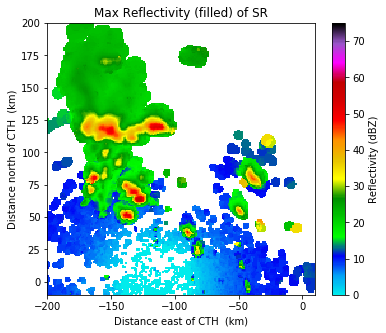

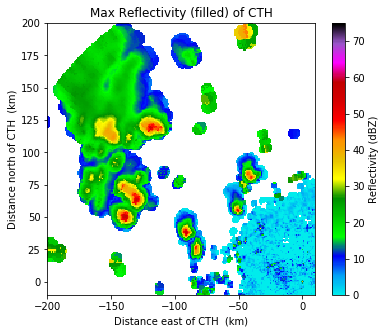

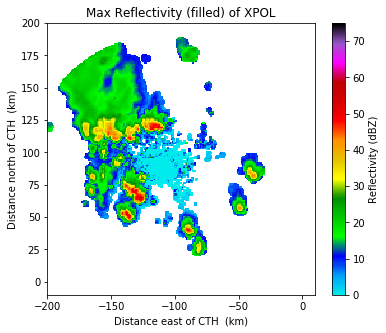

In [21]:
plot_gridded_radar(grid_1, 'SR', 'CTH')
plot_gridded_radar(grid_2, 'CTH', 'CTH')
plot_gridded_radar(grid_3, 'XPOL', 'CTH')

## Writing data to file

In [22]:
pyart.io.write_grid('radar_1.nc', grid_1)
pyart.io.write_grid('radar_2.nc', grid_2)
pyart.io.write_grid('radar_3.nc', grid_3)

## Loading parameters and updating

In [28]:
with open('multidop_parameters.txt','r') as file:
    params = literal_eval(file.read())

#### 3 Radars (SR, CTH, XPOL)

In [29]:
params['x'] = [grid_xlim[0], grid_spacing, grid_shape[1]]
params['y'] = [grid_ylim[0], grid_spacing, grid_shape[1]]
params['z'][1] = grid_spacing
params['grid'] = [grid_1.origin_longitude['data'][0], grid_1.origin_latitude['data'][0], 0.0]
params['files'].append('radar_3.nc')
params['radar_names'] = ['SR', 'CTH', 'XPOL']
params['writeout'] = tempfile.NamedTemporaryFile().name

In [30]:
params

{'C1b': 1.0,
 'C2b': 10.0,
 'C3b': 0,
 'C4b': 1.0,
 'C5b': 0.0,
 'C8b': 0.0,
 'UT': 0.0,
 'VT': 0.0,
 'anel': 1,
 'bgfile': None,
 'calc_params': 'calc.dda',
 'cutoff': 0.0,
 'cvg_bg': [0, 0, 0],
 'cvg_fil': [0, 0, 0],
 'cvg_opt_bg': [1, 1, 1],
 'cvg_opt_fil': [0, 1, 1],
 'cvg_sub_bg': [1, 1, 1],
 'cvg_sub_fil': [0, 0, 0],
 'dir': './',
 'files': ['radar_1.nc', 'radar_2.nc', 'radar_3.nc'],
 'filter': ['none', '', ''],
 'frprmn_out': 'frprmn_out.nc',
 'grid': [-45.97279, -23.600795, 0.0],
 'itmax_dbrent': 200,
 'itmax_frprmn': [200, 10],
 'laplace': 0,
 'max_dist': 10.0,
 'min_cba': 20.0,
 'output_error': 0,
 'radar_names': ['SR', 'CTH', 'XPOL'],
 'read_dataweights': 2,
 'refl': 'DT',
 'sseq_trip': [1.0, 1.0, 0.0],
 'upper_bc': 1,
 'vary_weights': 0,
 'vt': 'VT',
 'weak_height': -1,
 'writeout': '/tmp/tmpst7k5i',
 'x': [-200000.0, 1000.0, 211],
 'y': [-10000.0, 1000.0, 211],
 'z': [1000.0, 1000.0, 20]}

In [27]:
pd

{'C1b': 1.0,
 'C2b': 10.0,
 'C3b': 0,
 'C4b': 1.0,
 'C5b': 0.0,
 'C8b': 0.0,
 'UT': 0.0,
 'VT': 0.0,
 'anel': 1,
 'bgfile': None,
 'calc_params': 'calc_3rad.dda',
 'cutoff': 0.0,
 'cvg_bg': [0, 0, 0],
 'cvg_fil': [0, 0, 0],
 'cvg_opt_bg': [1, 1, 1],
 'cvg_opt_fil': [0, 1, 1],
 'cvg_sub_bg': [1, 1, 1],
 'cvg_sub_fil': [0, 0, 0],
 'dir': './',
 'files': ['sr.nc', 'cth.nc', 'xpol.nc'],
 'filter': ['none', '', ''],
 'frprmn_out': 'frprmn_out.nc',
 'grid': [-45.97279, -23.600795, 0.0],
 'itmax_dbrent': 200,
 'itmax_frprmn': [200, 10],
 'laplace': 0,
 'max_dist': 10.0,
 'min_cba': 20.0,
 'output_error': 0,
 'radar_names': ['SR', 'CTH', 'XPOL'],
 'read_cvg': 0,
 'read_dataweights': 2,
 'refl': 'DT',
 'sseq_trip': [1.0, 1.0, 0.0],
 'upper_bc': 1,
 'vary_weights': 0,
 'vt': 'VT',
 'weak_height': -1,
 'writeout': '/tmp/tmpDiz2id',
 'x': [-200000.0, 1000.0, 211],
 'y': [-10000.0, 1000.0, 211],
 'z': [1000.0, 1000.0, 20]}

In [31]:
pf = multidop.parameters.ParamFile(params, 'case_3rad.dda')
pf = multidop.parameters.CalcParamFile(params, 'calc_example.dda')

#### Executing DDA engine
Text output will display with delay

In [32]:
bt = time.time()
multidop.execute.do_analysis('case_3rad.dda', cmd_path='src/DDA')
print((time.time()-bt)/60.0, 'minutes to process')

DDA 0.9.0
./DDA: reading calculation parameters from calc.dda.
Changing working directory to ./
x: -200000.000000 to 10000.000000 in 210 steps of 1000.000000
y: -10000.000000 to 200000.000000 in 210 steps of 1000.000000
z: 1000.000000 to 20000.000000 in 19 steps of 1000.000000
z_min=1000, cutoff=0
UT=0, VT=0
Anelastic mass cons
First-order smoothness constraint
Minimum beam crossing angle = 20 degrees
Py-ART grids for analyis and all radars must match to within (dx, dy, dz) < (10 10 10) meters.
Reading Py-ART fileradar_1.nc
radar_2.nc
radar_3.nc

Radar positions:  (-114194,-581.287) (0.12019,-0.0946679) (-110974,87023)
0.0063790678978 minutes to process


In [9]:
filenames = open("filenames.txt").read().split('\n')

In [10]:
radar_1 = pyart.aux_io.read_gamic(filenames[0])
radar_2 = rbr.read_rainbow_hdf5(filenames[1])
radar_3 = rbr.read_rainbow_hdf5(filenames[2])
print(radar_1.fields.keys(), radar_2.fields.keys(), radar_3.fields.keys())

['spectrum_width', 'corrected_velocity', 'corrected_reflectivity', 'reflectivity'] ['corrected_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'filtered_differential_phase', 'spectrum_width', 'reflectivity', 'differential_reflectivity', 'specific_differential_phase', 'velocity'] ['corrected_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'filtered_differential_phase', 'spectrum_width', 'reflectivity', 'differential_reflectivity', 'specific_differential_phase', 'velocity']


### Performing corrections

In [11]:
cp = deepcopy(radar_1.fields['corrected_reflectivity']['data'])
radar_1.add_field_like('corrected_reflectivity', 'DT', cp, replace_existing=True)
gatefilter = pyart.correct.GateFilter(radar_1)
gatefilter.exclude_masked('corrected_reflectivity')
corr_vel = pyart.correct.dealias_region_based(radar_1, vel_field='corrected_velocity',
                                              keep_original=False, gatefilter=gatefilter,
                                              centered=True)
radar_1.add_field('VT', corr_vel, replace_existing=True)

/home/camila/anaconda2/lib/python2.7/site-packages/pyart/correct/region_dealias.py:267: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)
/home/camila/anaconda2/lib/python2.7/site-packages/pyart/correct/region_dealias.py:267: UserWarning: Velocities outside of the Nyquist interval found in sweep 1.
  warnings.warn(msg, UserWarning)
/home/camila/anaconda2/lib/python2.7/site-packages/pyart/correct/region_dealias.py:267: UserWarning: Velocities outside of the Nyquist interval found in sweep 2.
  warnings.warn(msg, UserWarning)
/home/camila/anaconda2/lib/python2.7/site-packages/pyart/correct/region_dealias.py:267: UserWarning: Velocities outside of the Nyquist interval found in sweep 3.
  warnings.warn(msg, UserWarning)
/home/camila/anaconda2/lib/python2.7/site-packages/pyart/correct/region_dealias.py:267: UserWarning: Velocities outside of the Nyquist interval found in sweep 4.
  warnings.warn(msg, UserWarning)
/home/camila/anacond

In [12]:
cp = deepcopy(radar_2.fields['corrected_reflectivity']['data'])
radar_2.add_field_like('corrected_reflectivity', 'DT', cp, replace_existing=True)
gatefilter = pyart.correct.GateFilter(radar_2)
gatefilter.exclude_masked('corrected_reflectivity')
corr_vel = pyart.correct.dealias_region_based(radar_2, vel_field='velocity',
                                              keep_original=False, gatefilter=gatefilter,
                                              centered=True)
radar_2.add_field('VT', corr_vel, replace_existing=True)

In [13]:
cp = deepcopy(radar_3.fields['corrected_reflectivity']['data'])
radar_3.add_field_like('corrected_reflectivity', 'DT', cp, replace_existing=True)
gatefilter = pyart.correct.GateFilter(radar_3)
gatefilter.exclude_masked('corrected_reflectivity')
corr_vel = pyart.correct.dealias_region_based(radar_3, vel_field='velocity',
                                              keep_original=False, gatefilter=gatefilter,
                                              centered=True)
radar_3.add_field('VT', corr_vel, replace_existing=True)

/home/camila/anaconda2/lib/python2.7/site-packages/pyart/correct/region_dealias.py:267: UserWarning: Velocities outside of the Nyquist interval found in sweep 7.
  warnings.warn(msg, UserWarning)
/home/camila/anaconda2/lib/python2.7/site-packages/pyart/correct/region_dealias.py:267: UserWarning: Velocities outside of the Nyquist interval found in sweep 8.
  warnings.warn(msg, UserWarning)
/home/camila/anaconda2/lib/python2.7/site-packages/pyart/correct/region_dealias.py:267: UserWarning: Velocities outside of the Nyquist interval found in sweep 9.
  warnings.warn(msg, UserWarning)
/home/camila/anaconda2/lib/python2.7/site-packages/pyart/correct/region_dealias.py:267: UserWarning: Velocities outside of the Nyquist interval found in sweep 10.
  warnings.warn(msg, UserWarning)
/home/camila/anaconda2/lib/python2.7/site-packages/pyart/correct/region_dealias.py:267: UserWarning: Velocities outside of the Nyquist interval found in sweep 11.
  warnings.warn(msg, UserWarning)
/home/camila/anaco

In [14]:
radar_1.fields['DT']['missing_value'] = 1.0 * radar_1.fields['DT']['_FillValue']
radar_2.fields['DT']['missing_value'] = 1.0 * radar_2.fields['DT']['data'].fill_value
radar_2.fields['DT']['_FillValue'] = radar_2.fields['DT']['data'].fill_value
radar_3.fields['DT']['missing_value'] = 1.0 * radar_3.fields['DT']['data'].fill_value
radar_3.fields['DT']['_FillValue'] = radar_3.fields['DT']['data'].fill_value
radar_1.fields['VT']['missing_value'] = 1.0 * radar_1.fields['VT']['_FillValue']
radar_2.fields['VT']['missing_value'] = 1.0 * radar_2.fields['VT']['data'].fill_value
radar_2.fields['VT']['_FillValue'] = radar_2.fields['VT']['data'].fill_value
radar_3.fields['VT']['missing_value'] = 1.0 * radar_3.fields['VT']['data'].fill_value
radar_3.fields['VT']['_FillValue'] = radar_3.fields['VT']['data'].fill_value

### Grid the volumes and add azimuths and elevations

In [15]:
def grid_radar(radar, grid_shape=(20, 301, 301), xlim=(-150000, 150000),
               ylim=(-150000, 150000), zlim=(1000, 20000),
               fields=['DT', 'VT'], origin=None):
    bt = time.time()
    radar_list = [radar]
    if origin is None:
        origin = (radar.latitude['data'][0],
                  radar.longitude['data'][0])
    grid = pyart.map.grid_from_radars(
        radar_list, grid_shape=grid_shape,
        grid_limits=(zlim, ylim, xlim),
        grid_origin=origin, fields=fields,
        gridding_algo='map_gates_to_grid', grid_origin_alt=0.0)
    print(time.time()-bt, 'seconds to grid radar')
    return grid

In [16]:
grid_1 = grid_radar(radar_1, origin=(radar_2.latitude['data'][0], radar_2.longitude['data'][0]),
                    xlim=(-200000, 10000), ylim=(-10000, 200000), grid_shape=(20, 211, 211))
grid_2 = grid_radar(radar_2, origin=(radar_2.latitude['data'][0], radar_2.longitude['data'][0]),
                    xlim=(-200000, 10000), ylim=(-10000, 200000), grid_shape=(20, 211, 211))
grid_3 = grid_radar(radar_3, origin=(radar_2.latitude['data'][0], radar_2.longitude['data'][0]),
                    xlim=(-200000, 10000), ylim=(-10000, 200000), grid_shape=(20, 211, 211))

/home/camila/anaconda2/lib/python2.7/site-packages/pyart/core/transforms.py:632: RuntimeWarning: invalid value encountered in sqrt
  rho = np.sqrt(x*x + y*y)


1.98462986946 seconds to grid radar
5.02172803879 seconds to grid radar
3.10717511177 seconds to grid radar


In [17]:
grid_1 = multidop.angles.add_azimuth_as_field(grid_1)
grid_2 = multidop.angles.add_azimuth_as_field(grid_2)
grid_3 = multidop.angles.add_azimuth_as_field(grid_3)
grid_1 = multidop.angles.add_elevation_as_field(grid_1)
grid_2 = multidop.angles.add_elevation_as_field(grid_2)
grid_3 = multidop.angles.add_elevation_as_field(grid_3)

## See gridded data

Text(0,0.5,'Distance north of CTH (km)')

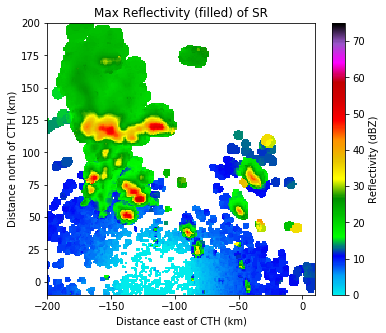

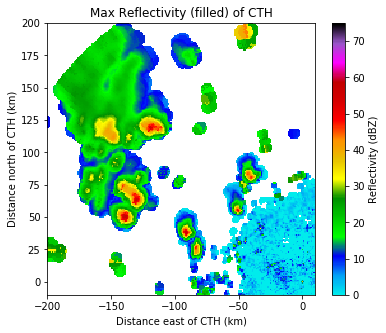

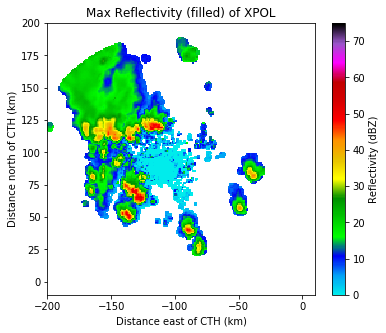

In [18]:
fig = plt.figure(figsize=(6, 5))
fig.set_facecolor('w')
DZcomp = np.amax(grid_1.fields['DT']['data'], axis=0)
x, y = np.meshgrid(0.001*grid_1.x['data'], 0.001*grid_1.y['data'])
cs = plt.pcolormesh(0.001*grid_1.x['data'], 0.001*grid_1.y['data'],
                    DZcomp, vmin=0, vmax=75, cmap='pyart_NWSRef')
plt.xlim(-200, 10)
plt.ylim(-10, 200)
plt.colorbar(cs, label='Reflectivity (dBZ)')
plt.title('Max Reflectivity (filled) of SR')
plt.xlabel('Distance east of CTH (km)')
plt.ylabel('Distance north of CTH (km)')

fig = plt.figure(figsize=(6, 5))
fig.set_facecolor('w')
DZcomp = np.amax(grid_2.fields['DT']['data'], axis=0)
x, y = np.meshgrid(0.001*grid_2.x['data'], 0.001*grid_2.y['data'])
cs = plt.pcolormesh(0.001*grid_2.x['data'], 0.001*grid_2.y['data'],
                    DZcomp, vmin=0, vmax=75, cmap='pyart_NWSRef')
plt.xlim(-200, 10)
plt.ylim(-10, 200)
plt.colorbar(cs, label='Reflectivity (dBZ)')
plt.title('Max Reflectivity (filled) of CTH')
plt.xlabel('Distance east of CTH (km)')
plt.ylabel('Distance north of CTH (km)')

fig = plt.figure(figsize=(6, 5))
fig.set_facecolor('w')
DZcomp = np.amax(grid_3.fields['DT']['data'], axis=0)
x, y = np.meshgrid(0.001*grid_3.x['data'], 0.001*grid_3.y['data'])
cs = plt.pcolormesh(0.001*grid_3.x['data'], 0.001*grid_3.y['data'],
                    DZcomp, vmin=0, vmax=75, cmap='pyart_NWSRef')
plt.xlim(-200, 10)
plt.ylim(-10, 200)
plt.colorbar(cs, label='Reflectivity (dBZ)')
plt.title('Max Reflectivity (filled) of XPOL')
plt.xlabel('Distance east of CTH (km)')
plt.ylabel('Distance north of CTH (km)')

In [19]:
pyart.io.write_grid('sr.nc', grid_1)
pyart.io.write_grid('cth.nc', grid_2)
pyart.io.write_grid('xpol.nc', grid_3)

## Start MultiDop

### 3 Radars

In [20]:
# You don't have to define everything. Most of these keywords are default values.
# If you don't define something the program will provide a default value.
# Check parameters.py for what keyword default values are.
localfile = tempfile.NamedTemporaryFile()
pd = {'dir': './',
      'refl': 'DT',  # Name of reflectivity field. Must be common between radars.
      'vt': 'VT',  # Name of velocity field. Must be common between radars.
      'bgfile': None,
      'writeout': localfile.name,
      'min_cba': 20.0,  # Minimum beam-crossing angle
      'calc_params': 'calc_3rad.dda',
      'anel': 1,
      'laplace': 0,
      'read_dataweights': 2,
      'max_dist': 10.0,
      'cutoff': 0.0,
      'UT': 0.0,
      'VT': 0.0,
      'output_error': 0,
      'weak_height': -1,
      'upper_bc': 1,
      'itmax_frprmn': [200, 10],
      'itmax_dbrent': 200,
      'C1b': 1.0,  # Data weighting factor
      'C2b': 10.0,  # Mass continuity weighting factor
      'C3b': 0,  # Vorticity weighting factor
      'C4b': 1.0,  # Horizontal smoothing factor
      'C5b': 0.0,  # Vertical smoothing factor
      'C8b': 0.0,  # Sounding factor
      'vary_weights': 0,
      'filter': ['none', '', ''],
      'cvg_opt_bg': [1, 1, 1],
      'cvg_sub_bg': [1, 1, 1],
      'cvg_opt_fil': [0, 1, 1],
      'cvg_sub_fil': [0, 0, 0],
      'cvg_bg': [0, 0, 0],
      'cvg_fil': [0, 0, 0],
      'sseq_trip': [1.0, 1.0, 0.0],
      'x': [-200000.0, 1000.0, 211],
      'y': [-10000.0, 1000.0, 211],
      'z': [1000.0, 1000.0,  20],
      'grid': [grid_1.origin_longitude['data'][0], grid_1.origin_latitude['data'][0], 0.0],
      'files': ['sr.nc',
                'cth.nc',
                'xpol.nc'],
      'radar_names': ['SR', 'CTH', 'XPOL']
     }
pf = multidop.parameters.ParamFile(pd, 'example_3rad.dda')
pf = multidop.parameters.CalcParamFile(pd, 'calc_3rad.dda')

In [21]:
# Unfortunately, text output from the analysis engine (DDA) will not display
# until after the program completes. Expect this step to take several minutes.
bt = time.time()
multidop.execute.do_analysis('example_3rad.dda', cmd_path='src/DDA')
print((time.time()-bt)/60.0, 'minutes to process')

DDA 0.9.0
./DDA: reading calculation parameters from calc_3rad.dda.
Changing working directory to ./
x: -200000.000000 to 10000.000000 in 210 steps of 1000.000000
y: -10000.000000 to 200000.000000 in 210 steps of 1000.000000
z: 1000.000000 to 20000.000000 in 19 steps of 1000.000000
z_min=1000, cutoff=0
UT=0, VT=0
Anelastic mass cons
First-order smoothness constraint
Minimum beam crossing angle = 20 degrees
Py-ART grids for analyis and all radars must match to within (dx, dy, dz) < (10 10 10) meters.
Reading Py-ART filesr.nc
cth.nc
xpol.nc

Radar positions:  (-114194,-581.287) (0.12019,-0.0946679) (-110974,87023)
Computing coverage: 94500 verification points out of 890420 total points.
radar0 100226 obs. radar1 158397 obs. radar2 74887 obs. 333510 total obs.
Analyzed obs = 333510. Mean Vr = 6.6886
C1b=1 C2b=10 C3b=0 C4b=1 C5b=0 C6b=0 C7b=1 C8b=0
C2a=10 C3a=0 C4a=1 C5a=0 C6a=0 C7a=1 C8a=0
Weighting all obs equally!
GradCheck: rchek = 1e+10. fx1 = 143872
GradCheck: gxnn = 16943.7
GradChec

In [22]:
# Baseline output is not CF or Py-ART compliant. This function fixes that.
# This is why we wrote the original output to a tempfile that can be safely removed.
# The final grid will have all wind solutions outside the coverage region masked.
fname = 'cf_compliant_grid_3rad.nc'
final_grid_3rad = multidop.grid_io.make_new_grid([grid_1, grid_2, grid_3], localfile.name)
final_grid_3rad.write(fname)
localfile.close()

### 2 Radars

In [ ]:
# 2 RADARS
# You don't have to define everything. Most of these keywords are default values.
# If you don't define something the program will provide a default value.
# Check parameters.py for what keyword default values are.
localfile = tempfile.NamedTemporaryFile()
pd = {'dir': './',
      'x': [-200000.0, 1000.0, 211],
      'y': [-10000.0, 1000.0, 211],
      'z': [1000.0, 1000.0,  20],
      'grid': [grid_1.origin_longitude['data'][0], grid_1.origin_latitude['data'][0], 0.0],
      'files': ['sr.nc',
                'cth.nc'],
      'radar_names': ['SR', 'CTH'],
      'refl': 'DT',  # Name of reflectivity field. Must be common between radars.
      'vt': 'VT',  # Name of velocity field. Must be common between radars.
      'bgfile': None,
      'writeout': localfile.name,
      'min_cba': 20.0,  # Minimum beam-crossing angle
      'calc_params': 'calc_2rad.dda',
      'anel': 1,
      'laplace': 0,
      'read_dataweights': 2,
      'max_dist': 10.0,
      'cutoff': 0.0,
      'UT': 0.0,
      'VT': 0.0,
      'output_error': 0,
      'weak_height': -1,
      'upper_bc': 1,
      'itmax_frprmn': [200, 10],
      'itmax_dbrent': 200,
      'C1b': 1.0,  # Data weighting factor
      'C2b': 10.0,  # Mass continuity weighting factor
      'C3b': 0,  # Vorticity weighting factor
      'C4b': 1.0,  # Horizontal smoothing factor
      'C5b': 0.0,  # Vertical smoothing factor
      'C8b': 0.0,  # Sounding factor
      'vary_weights': 0,
      'filter': ['none', '', ''],
      'cvg_opt_bg': [1, 1, 1],
      'cvg_sub_bg': [1, 1, 1],
      'cvg_opt_fil': [0, 1, 1],
      'cvg_sub_fil': [0, 0, 0],
      'cvg_bg': [0, 0, 0],
      'cvg_fil': [0, 0, 0],
      'sseq_trip': [1.0, 1.0, 0.0]
     }
pf = multidop.parameters.ParamFile(pd, 'example_2rad.dda')
pf = multidop.parameters.CalcParamFile(pd, 'calc_2rad.dda')

In [ ]:
# Unfortunately, text output from the analysis engine (DDA) will not display
# until after the program completes. Expect this step to take several minutes.
bt = time.time()
multidop.execute.do_analysis('example_2rad.dda', cmd_path='src/DDA')
print((time.time()-bt)/60.0, 'minutes to process')

In [ ]:
# Baseline output is not CF or Py-ART compliant. This function fixes that.
# This is why we wrote the original output to a tempfile that can be safely removed.
# The final grid will have all wind solutions outside the coverage region masked.
fname = 'cf_compliant_grid_2rad.nc'
final_grid_2rad = multidop.grid_io.make_new_grid([grid_1, grid_2], localfile.name)
final_grid_2rad.write(fname)
localfile.close()

## Reading results in Py-ART

In [23]:
# pyart_grid = pyart.io.read_grid(fname)
pyart_grid = final_grid_3rad
print(pyart_grid.fields.keys())

['eastward_wind', 'upward_air_velocity', 'northward_wind', 'reflectivity']


## First look

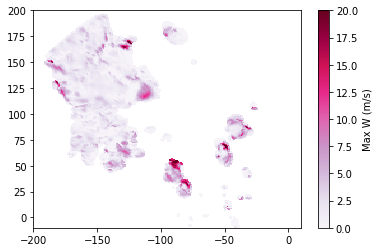

In [24]:
cs = plt.pcolormesh(0.001*pyart_grid.x['data'], 0.001*pyart_grid.y['data'],
                    np.amax(pyart_grid.fields['upward_air_velocity']['data'], axis=0),
                    vmin=0, vmax=20, cmap='PuRd')
plt.colorbar(cs, label='Max W (m/s)')

Text(0,0.5,'Distance north of CTH (km)')

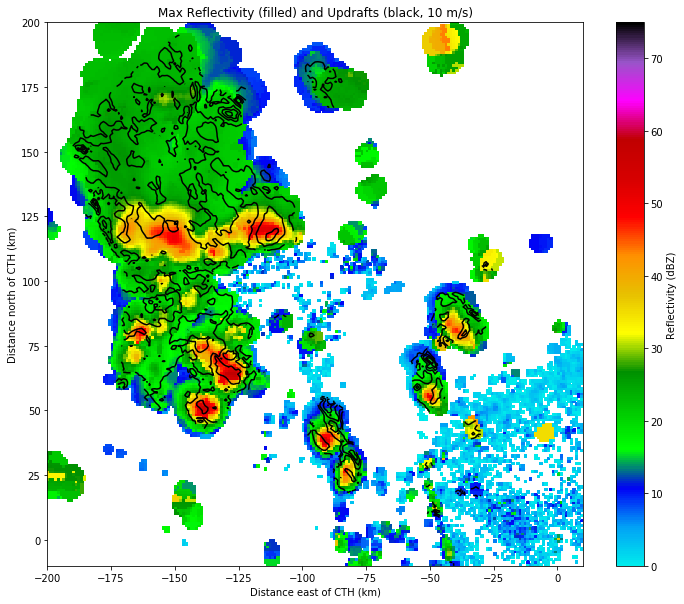

In [25]:
fig = plt.figure(figsize=(12, 10))
fig.set_facecolor('w')
DZcomp = np.amax(pyart_grid.fields['reflectivity']['data'], axis=0)
x, y = np.meshgrid(0.001*pyart_grid.x['data'], 0.001*pyart_grid.y['data'])
cs = plt.pcolormesh(0.001*pyart_grid.x['data'], 0.001*pyart_grid.y['data'],
                    DZcomp, vmin=0, vmax=75, cmap='pyart_NWSRef')
Wcomp = np.amax(pyart_grid.fields['upward_air_velocity']['data'], axis=0)
plt.contour(x, y, Wcomp, levels=[1, 6, 11, 16, 21], colors=['k', 'k', 'k'])
plt.xlim(-200, 10)
plt.ylim(-10, 200)
plt.colorbar(cs, label='Reflectivity (dBZ)')
plt.title('Max Reflectivity (filled) and Updrafts (black, 10 m/s)')
plt.xlabel('Distance east of CTH (km)')
plt.ylabel('Distance north of CTH (km)')

## Focusing on system

In [26]:
# Selecting data
U = pyart_grid.fields['eastward_wind']['data']
V = pyart_grid.fields['northward_wind']['data']
W = pyart_grid.fields['upward_air_velocity']['data']
Z = pyart_grid.fields['reflectivity']['data']

# Grid
x, y = np.meshgrid(0.001*pyart_grid.x['data'], 0.001*pyart_grid.y['data'])

# General setup
ind = 2 # level
thin = 2 # wind grid

# Wind medians - necessary?
Um = np.ma.median(U[ind])
Vm = np.ma.median(V[ind])

### Horizontal view

#### 3 radars

Text(0.5,1,'CTH/SR/XPOL U & V, W (contours, m/s), & dBZ @ 3 km MSL')

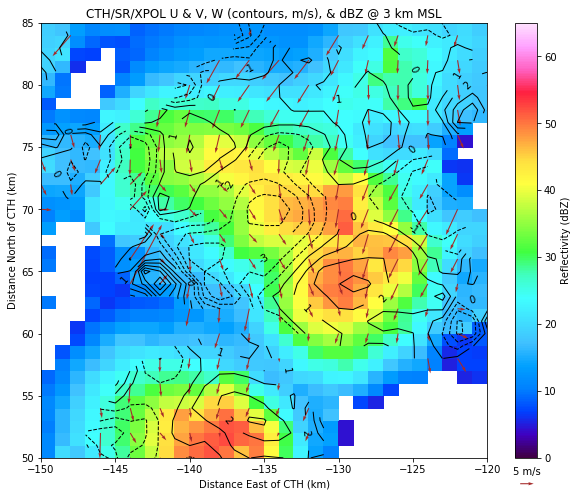

In [27]:
# Main figure
fig = plt.figure(figsize=(10, 8))
fig.set_facecolor('w')
ax = fig.add_subplot(111)

# Reflectivity (shaded)
cs = ax.pcolormesh(0.001*pyart_grid.x['data'], 0.001*pyart_grid.y['data'],
                   Z[ind], vmin=0, vmax=65, cmap=cm.GMT_wysiwyg)
plt.colorbar(cs, label='Reflectivity (dBZ)', ax=ax)

# Vertical wind (contour)
cl = plt.contour(x, y, W[ind], levels=range(-20, 20), colors=['k'], linewidths=1)
plt.clabel(cl, inline=1, fontsize=10, fmt='%1.0f', inline_spacing=0.01)

# Wind arrows
wind = ax.quiver(x[::thin, ::thin], y[::thin, ::thin], U[ind][::thin, ::thin],
                 V[ind][::thin, ::thin], scale=5, units='xy',
                 color='brown', label='Winds (m/s)')
ax.quiverkey(wind, 0.8, 0.08, 5, '5 m/s', coordinates='figure')

# General aspects
ax.set_xlim(-150, -120)
ax.set_ylim(50, 85)
ax.set_xlabel('Distance East of CTH (km)')
ax.set_ylabel('Distance North of CTH (km)')
ax.set_title('CTH/SR/XPOL U & V, W (contours, m/s),' +
             ' & dBZ @ '+str(ind+1)+' km MSL')

#### 2 radars

In [ ]:
# Main figure
fig = plt.figure(figsize=(10, 8))
fig.set_facecolor('w')
ax = fig.add_subplot(111)

# Reflectivity (shaded)
cs = ax.pcolormesh(0.001*pyart_grid.x['data'], 0.001*pyart_grid.y['data'],
                   Z[ind], vmin=0, vmax=65, cmap=cm.GMT_wysiwyg)
plt.colorbar(cs, label='Reflectivity (dBZ)', ax=ax)

# Vertical wind (contour)
cl = plt.contour(x, y, W[ind], levels=range(-20, 20), colors=['k'], linewidths=1)
plt.clabel(cl, inline=1, fontsize=10, fmt='%1.0f', inline_spacing=0.01)

# Wind arrows
wind = ax.quiver(x[::thin, ::thin], y[::thin, ::thin], U[ind][::thin, ::thin],
                 V[ind][::thin, ::thin], scale=5, units='xy',
                 color='brown', label='Winds (m/s)')
ax.quiverkey(wind, 0.8, 0.08, 5, '5 m/s', coordinates='figure')

# General aspects
ax.set_xlim(-150, -120)
ax.set_ylim(50, 85)
ax.set_xlabel('Distance East of CTH (km)')
ax.set_ylabel('Distance North of CTH (km)')
ax.set_title('CTH/SR U & V, W (contours, m/s),' +
             ' & dBZ @ '+str(ind+1)+' km MSL')

### Vertical view

In [28]:
# Grid
y_cs, z_cs = np.meshgrid(0.001*pyart_grid.y['data'], 0.001*pyart_grid.z['data'])

# Wind medians - necessary?
Wm = np.ma.median([W[i][:,71] for i in range(0,20)])

#### 3 radars

Text(0.5,1,'CTH/SR/XPOL V & W, W (contours, m/s), & dBZ @ -129.0 km East of CTH')

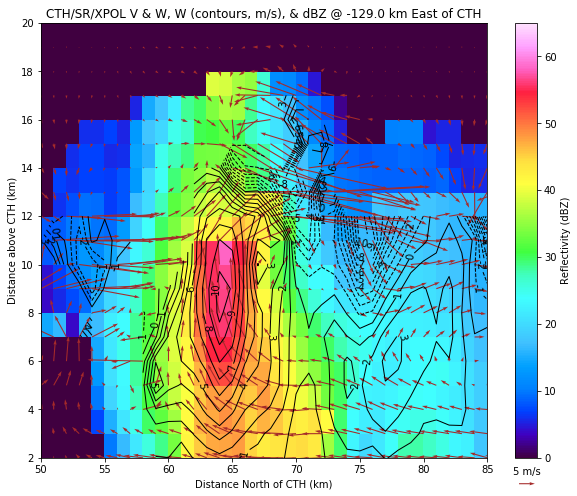

In [30]:
# Main figure
fig = plt.figure(figsize=(10, 8))
fig.set_facecolor('w')
ax = fig.add_subplot(111)

# Reflectivity (shaded)
cs = ax.pcolormesh(0.001*pyart_grid.y['data'], 0.001*pyart_grid.z['data'],
                   [Z[i][:,71] for i in range(0,20)], vmin=0, vmax=65,
                   cmap=cm.GMT_wysiwyg)
plt.colorbar(cs, label='Reflectivity (dBZ)', ax=ax)

# Vertical wind (contour)
cl = plt.contour(y_cs, z_cs, [W[i][:,71] for i in range(0,20)], 
                 levels=range(-20, 20), colors=['k'], linewidths=1)
plt.clabel(cl, inline=1, fontsize=10, fmt='%1.0f', inline_spacing=0.01)

# Wind barbs
wind = ax.quiver(y_cs, z_cs, [V[i][:,71] for i in range(0,20)],
                 [W[i][:,71] for i in range(0,20)], scale=5, units='xy', 
                 color='brown', label='Winds (m/s)')
ax.quiverkey(wind, 0.8, 0.08, 5, '5 m/s', coordinates='figure')

ax.set_xlim(50, 85)
ax.set_ylim(2, 20)
ax.set_xlabel('Distance North of CTH (km)')
ax.set_ylabel('Distance above CTH (km)')
ax.set_title('CTH/SR/XPOL V & W, W (contours, m/s),' +
             ' & dBZ @ '+str(x[0,71])+' km East of CTH')

#### 2 radars

In [ ]:
# Main figure
fig = plt.figure(figsize=(10, 8))
fig.set_facecolor('w')
ax = fig.add_subplot(111)

# Reflectivity (shaded)
cs = ax.pcolormesh(0.001*pyart_grid.y['data'], 0.001*pyart_grid.z['data'],
                   [Z[i][:,71] for i in range(0,20)], vmin=0, vmax=65,
                   cmap=cm.GMT_wysiwyg)
plt.colorbar(cs, label='Reflectivity (dBZ)', ax=ax)

# Vertical wind (contour)
cl = plt.contour(y_cs, z_cs, [W[i][:,71] for i in range(0,20)], 
                 levels=range(-20, 20), colors=['k'], linewidths=1)
plt.clabel(cl, inline=1, fontsize=10, fmt='%1.0f', inline_spacing=0.01)

# Wind barbs
wind = ax.quiver(y_cs, z_cs, [V[i][:,71] for i in range(0,20)],
                 [W[i][:,71] for i in range(0,20)], scale=5, units='xy', 
                 color='brown', label='Winds (m/s)')
ax.quiverkey(wind, 0.8, 0.08, 5, '5 m/s', coordinates='figure')

ax.set_xlim(50, 85)
ax.set_ylim(2, 20)
ax.set_xlabel('Distance North of CTH (km)')
ax.set_ylabel('Distance above CTH (km)')
ax.set_title('CTH/SR V & W, W (contours, m/s),' +
             ' & dBZ @ '+str(x[0,71])+' km East of CTH')